这个notebook用来可视化CRNN模型的能力

In [1]:
import torch
from torch import nn
from torchvision import models
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
from utils import *

In [2]:
# 这个是从另一个记事本中复制过来的，懒得改了

def get_model_name(epoch, name):
    return f"{name}_{epoch}.pth"

class CRNN(nn.Module):
    """
    这是一个基于CNN和LSTM的CRNN模型，用于生成文本

    """
    def __init__(self, num_classes=128, hidden_dim=1024, io_dim=1024, num_layers=4, bidirectional=True, device='cuda:0'):
        """
        args:
            num_classes: ...
            hidden_dim: int, the dimension of the hidden state of the LSTM
            io_dim: int, the dimension of the input and output of the LSTM
            num_layers: int, the number of layers of the LSTM
            bidirectional: bool, whether to use bidirectional LSTM
            device: str, the device
        """
        super(CRNN, self).__init__()
        self.direction_factor = 2 if bidirectional else 1
        self.num_layers = num_layers
        # num-classes对应ascii码表的128种字符
        self.num_classes = num_classes
        # hidden_dim是LSTM的隐藏层（hidden state）和细胞状态（cell state）的维度
        self.hidden_dim = hidden_dim
        # io_dim是LSTM的输入和输出的维度
        self.io_dim = io_dim
        self.device = device
        # max num of characters of the generated text
        self.max_len = 64
        # 1x1卷积层，用于将灰度图转换为3通道图像以适应ResNet的输入
        self.conv1 = nn.Conv2d(1, 3, 1)
        # 使用ResNet50作为CNN的基础模型，去掉最后一层全连接层
        self.cnn = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # output dim is 2048
        # LSTM层，输入维度为io_dim，隐藏层维度为hidden_dim
        self.rnn = nn.LSTM(io_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        # 将CNN的输出转换为LSTM的隐藏状态和细胞状态
        self.h0_fc = nn.Linear(2048, hidden_dim * num_layers * self.direction_factor)
        self.c0_fc = nn.Linear(2048, hidden_dim * num_layers * self.direction_factor)
        # 将LSTM的输出转换为最终的输出，即字符概率分布
        self.out_fc = nn.Linear(hidden_dim * self.direction_factor, num_classes)
        # 将字符的索引转换为字符的embedding
        self.embedding = nn.Embedding(num_classes, io_dim)
        # dropout防止过拟合
        self.dropout = nn.Dropout(0.75)
        self.to(device)
    
    def init_state(self, img):
        # 通过CNN卷出 lstm 的 hidden state 和 cell state
        x = self.conv1(img)         # batch_size, 3, 64, 64
        x = self.cnn(x)             # batch_size, 512, 1, 1
        x = x.view(x.size(0), -1)   # batch_size, 512
        x = x.unsqueeze(0)          # 1, batch_size, 512
        h0 = self.h0_fc(x)          # 1, batch_size, hidden_dim
        c0 = self.c0_fc(x)          # 1, batch_size, hidden_dim
        h0 = h0.view(-1, self.hidden_dim, self.num_layers * self.direction_factor).permute(2, 0, 1).contiguous()  # 4, batch_size, hidden_dim
        c0 = c0.view(-1, self.hidden_dim, self.num_layers * self.direction_factor).permute(2, 0, 1).contiguous()  # 4, batch_size, hidden_dim
        return h0, c0
    
    def next_char(self, x, h_c_n):
        # print("next char x shape: ", x.shape)
        h_n, c_n = h_c_n
        # x: the embedding of the last character
        # h_n: the hidden state of the last character
        # c_n: the cell state of the last character
        x, (h_n, c_n) = self.rnn(x, (h_n, c_n))
        # print("next char rnn output x shape: ", x.shape)
        x = self.out_fc(x)
        # x = self.dropout(x)
        # print("next char output x shape: ", x.shape)
        return x, (h_n, c_n)
    
    def forward(self, img):
        batch_size = img.size(0)
        h0, c0 = self.init_state(img)
        x = 2  # the index of the start token
        x = torch.tensor([x] * batch_size, dtype=torch.long).view(batch_size, 1).to(self.device)
        x = self.embedding(x)
        # print("after embedding x shape: ", x.shape)
        h_c_n = (h0, c0)
        temp = torch.zeros(batch_size, 1, self.num_classes).to(self.device)
        temp[:, 0, 2] = 1
        output = [temp]
        for i in range(1, self.max_len):
            x, h_c_n = self.next_char(x, h_c_n)
            output.append(x)
            x = x.argmax(dim=-1)
            x = self.embedding(x)
        output = torch.cat(output, dim=1)
        return output

In [5]:
# load model
model = CRNN()
model_name = get_model_name(0, "CRNN")
model_path = "/root/autodl-tmp/APS360_Project/Machine_Learning_Output/CRNN/"
model.load_state_dict(torch.load(model_path + model_name, weights_only=True))
model.to("cuda:0")
model.eval()

def show_img(img):
    img = img.squeeze().cpu().numpy()
    plt.imshow(img, cmap="gray")
    plt.show()

def get_word(output):
    output = output.cpu().detach().numpy()
    word = ""
    for i in range(1, 64):
        o = np.argmax(output[i])
        if o == 3:
            break
        c = chr(o)
        word += c
    return word

# test
import random
class RandomNegate:
    def __call__(self, sample):
        if random.random() > 0.5:
            return -sample
        return sample
trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

dataset = RecDataset("IAM", "val")
train_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

42.0123.052.0   255.0255.0255.0   243.80096435546875225.876953125209.65618896484375   49.91555023193359437.3898582458496132.17037582397461


39.049.0  22.076.0255.0  246.586181640625255.0  28.95633888244629 
242.78656005859375255.0 255.037.07242965698242
  230.87774658203125246.43865966796875  61.056.82794570922851625.73505210876465

23.0 255.0  246.1727294921875 255.030.77113151550293 
245.07293701171875
25.61817741394043 answer:  for


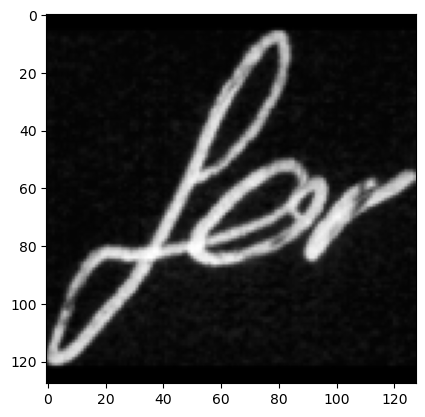

In [6]:
for step, (img, label) in enumerate(train_loader):
    img, label = img.to("cuda:0"), label.to("cuda:0")
    # output = model(img)
    # print("predict:", get_word(output[0]))
    print("answer: ", get_word(label[0]))
    img = img[0]
    # img -= img.min()
    # img /= img.max()
    
    show_img(img)
    plt.show()
    break